![tutorialpromo](images/tutorial_banner.PNG)


# Tutorial 5 - Array Power

This notebook shows how to use pvlib to model an array's output power given POA irradiance and cell temperature.

The physics of a solar cell are fairly complex.  Models of a cell's response to light and temperature range from high-level approximations that need only one or two coefficients, to electrical circuit models that require more detailed cell characteristics, to full physics-based semiconductor models.  The level of detail should match the application -- first-order approximations can be surprisingly accurate but probably shouldn't be used for financial decisions, while physics-based semiconductor models are rarely practical outside of a laboratory setting.

## Simple PVWatts array power

Here we will demonstrate one of the more basic PV models implemented by pvlib.  The PVWatts module model requires only two array parameters -- the array size (nameplate capacity) and the array's efficiency change with cell temperature.  Typical array sizes range from a few kW for residential arrays to hundreds of MW for large utility-scale systems.  The cell temperature response parameter, often called the module's temperature coefficient, determines the efficiency loss for a temperature increase.  For example, a module that produces 100W at test conditions but only 95W when the cell temperature is increased by 10 degrees has a temperature coefficient of -0.5%/°C.  Typical temperature coefficients range from -0.5%/°C to -0.2%/°C.

We'll read in weather data, run the irradiance transposition, and model cell temperature as in previous tutorials:

In [1]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install -r https://raw.githubusercontent.com/PVSC-Python-Tutorials/PVSC50/main/requirements.txt

In [2]:
import pvlib
import pandas as pd  # for data wrangling
import matplotlib.pyplot as plt  # for visualization
import pathlib  # for finding the example dataset

print(pvlib.__version__)

0.9.4.dev19+ge4356f9


In [3]:
DATA_DIR = pathlib.Path(pvlib.__file__).parent / 'data'
df_tmy, metadata = pvlib.iotools.read_tmy3(DATA_DIR / '723170TYA.CSV', coerce_year=1990)

location = pvlib.location.Location(latitude=metadata['latitude'],
                                   longitude=metadata['longitude'])

times = df_tmy.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
solar_position.index += pd.Timedelta('30min')

tracker_data = pvlib.tracking.singleaxis(solar_position['apparent_zenith'],
                                         solar_position['azimuth'],
                                         axis_azimuth=180,
                                         )
tilt = tracker_data['surface_tilt'].fillna(0)
azimuth = tracker_data['surface_azimuth'].fillna(0)

df_poa_tracker = pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,
                                                       surface_azimuth=azimuth,
                                                       dni=df_tmy['DNI'],
                                                       ghi=df_tmy['GHI'],
                                                       dhi=df_tmy['DHI'],
                                                       solar_zenith=solar_position['apparent_zenith'],
                                                       solar_azimuth=solar_position['azimuth'])
tracker_poa = df_poa_tracker['poa_global']

parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
cell_temperature = pvlib.temperature.sapm_cell(tracker_poa,
                                               df_tmy['DryBulb'],
                                               df_tmy['Wspd'],
                                               **parameters)

For demonstration purposes, we'll assume a 1kW array with a temperature coefficient of -0.4%/°C:

In [4]:
gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C
nameplate = 1e3

array_power = pvlib.pvsystem.pvwatts_dc(tracker_poa, cell_temperature, nameplate, gamma_pdc)

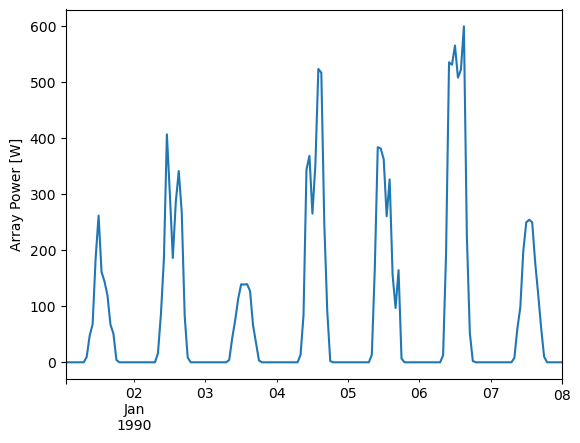

In [5]:
array_power.head(24*7).plot()
plt.ylabel('Array Power [W]');

Let's take a look at the array's response to irradiance and temperature:

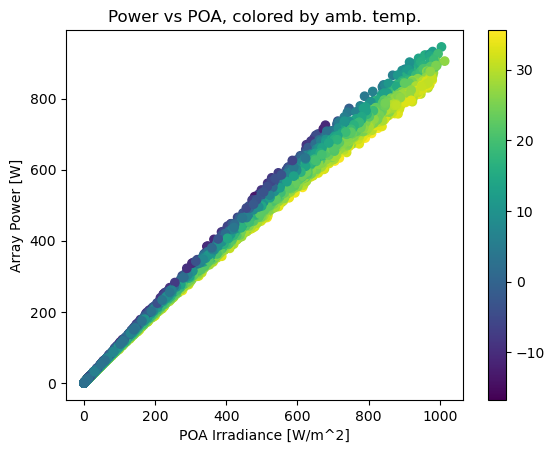

In [6]:
plt.scatter(tracker_poa, array_power, c=df_tmy['DryBulb'])
plt.colorbar()
plt.ylabel('Array Power [W]')
plt.xlabel('POA Irradiance [W/m^2]')
plt.title('Power vs POA, colored by amb. temp.');

This plot shows a strong, near-linear trend of power with POA irradiance.  However, it also shows a performance change with temperature -- as ambient temperature increases, array output drops.  The gradient is smoother if we color by cell temperature:

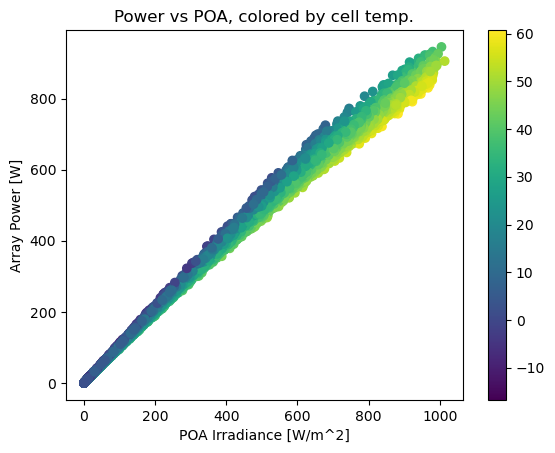

In [7]:
plt.scatter(tracker_poa, array_power, c=cell_temperature)
plt.colorbar()
plt.ylabel('Array Power [W]')
plt.xlabel('POA Irradiance [W/m^2]')
plt.title('Power vs POA, colored by cell temp.');

We can also compare with a hypothetical module with a smaller temperature coefficient, which shows a correspondingly smaller temperature effect:

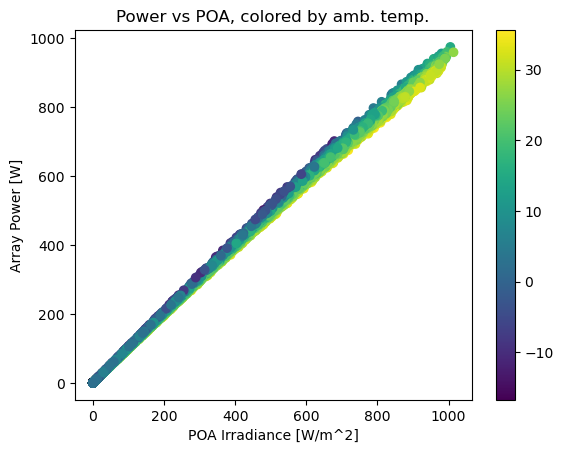

In [8]:
array_power_low_tempco = pvlib.pvsystem.pvwatts_dc(tracker_poa, cell_temperature, nameplate, -0.002)
plt.scatter(tracker_poa, array_power_low_tempco, c=df_tmy['DryBulb'])
plt.colorbar()
plt.ylabel('Array Power [W]')
plt.xlabel('POA Irradiance [W/m^2]')
plt.title('Power vs POA, colored by amb. temp.');

Another way of viewing the temperature effect is to compare monthly energy production with monthly POA insolation, noticing how production dips relative to insolation in the summertime.  Note that insolation and production happen to be about the same scale here; that's just a coincidence because of the array size we chose.

Text(0, 0.5, 'Energy [Wh]')

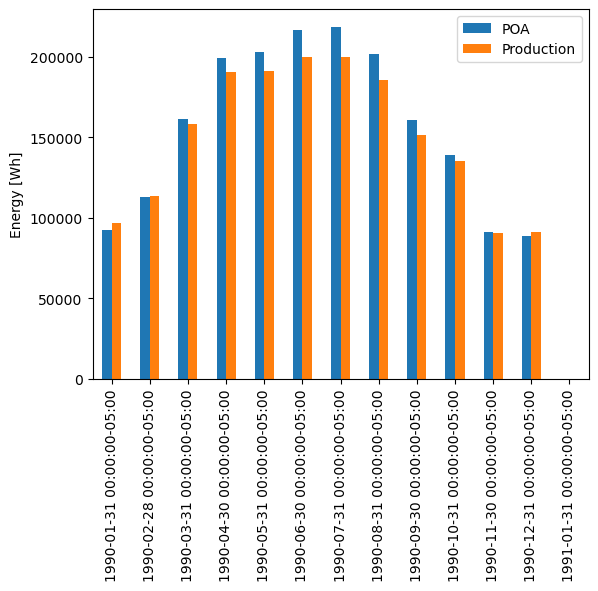

In [9]:
df_plot = pd.DataFrame({
    'POA': tracker_poa,
    'Production': array_power,
})
# summing hourly power (W) gives (W h)
df_plot.resample('M').sum().plot.bar()
plt.ylabel('Energy [Wh]')

## AC/DC
PVWatts has a simplified inverter model. Use [`pvlib.inverter.pvwatts(pdc, pdc0)`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.inverter.pvwatts.html) to return the AC output given DC output, `pdc`, and the DC limit, `pdc0` which is the AC rated power over the nominal inverter efficiency.

Recall we assumed a 1kW array, so we'll continue the hypothetical case and assume an AC size of 800W, a DC/AC ratio of 1.2. The default PVWatts nominal inverter efficiency is 0.96 which we use to get `pdc0`.

In [10]:
pdc0 = 800/0.96  # W
ac = pvlib.inverter.pvwatts(array_power, pdc0)

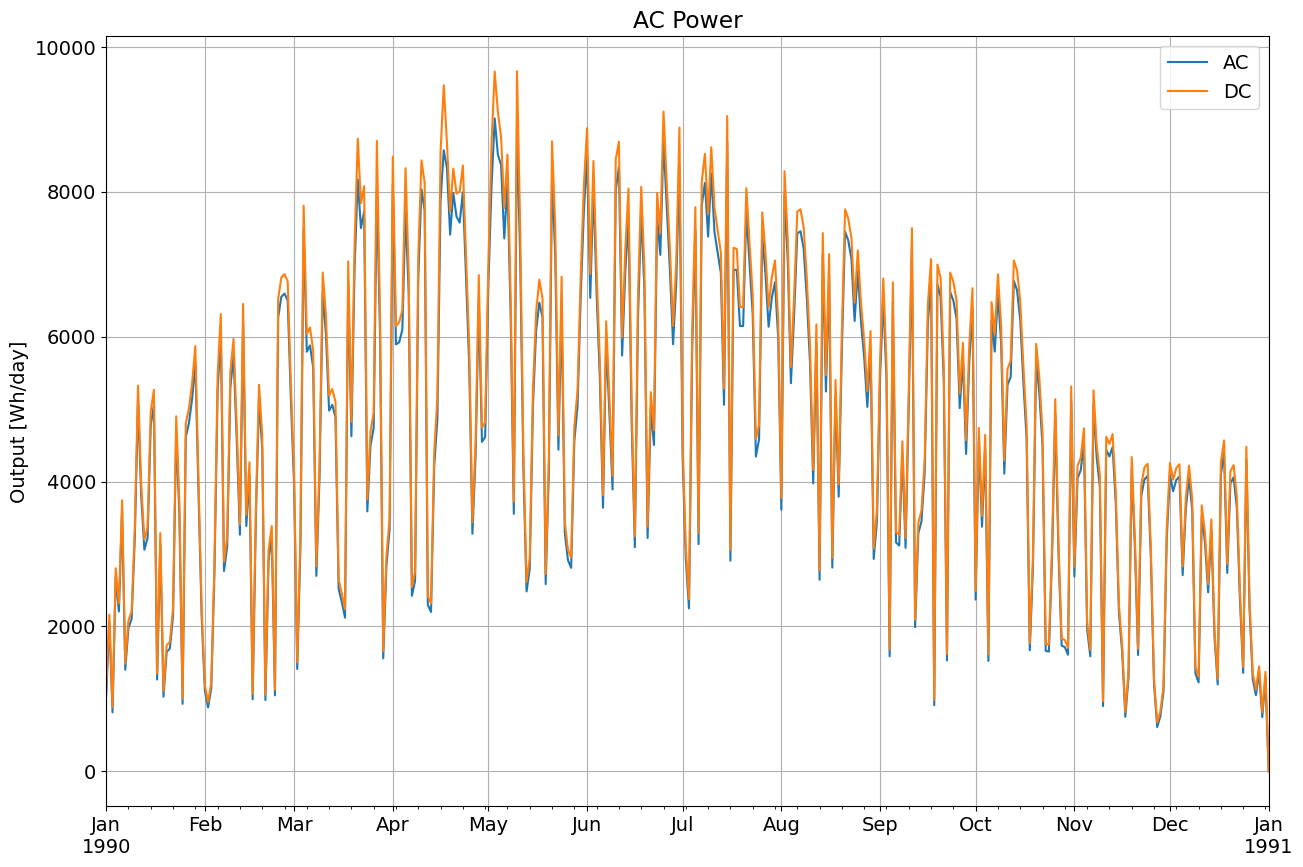

In [11]:
plt.rcParams['font.size'] = 14
ax = ac.resample('D').sum().plot(figsize=(15, 10), label='AC')
array_power.resample('D').sum().plot(ax=ax, label='DC')
plt.title('AC Power')
plt.ylabel('Output [Wh/day]')
plt.grid()
plt.legend()

[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).